In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import gc
from numpy import nan 


from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
#from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import ruptures as rpt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


from sklearn.linear_model import Ridge
from statsmodels.tsa.statespace.sarimax import SARIMAX




import os
for dirname, _, filenames in os.walk('C:/Users/tomas/Documents/GitHub/Adaptative_Ensemble_methods_for_time_series_forecast/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/tomas/Documents/GitHub/Adaptative_Ensemble_methods_for_time_series_forecast/data\Times_Series_Project_uoc.xlsx


In [2]:
#!pip install xgboost

Data loading

In [3]:
PATH_FILE = 'C:/Users/tomas/Documents/GitHub/Adaptative_Ensemble_methods_for_time_series_forecast/data/Times_Series_Project_uoc.xlsx'

Others_Europe = pd.read_excel(PATH_FILE, 'Others_Europe')
Continental_Europe2 = pd.read_excel(PATH_FILE, 'Continental_Europe2')
Continental_Europe = pd.read_excel(PATH_FILE, 'Continental_Europe')
Latam = pd.read_excel(PATH_FILE, 'Latam')
Central_Europe = pd.read_excel(PATH_FILE, 'Central_Europe')
Asia = pd.read_excel(PATH_FILE, 'Asia')

Let's see some rows

In [4]:
Continental_Europe.head(10)

,date,sales_city1,sales_city2,sales_city3,humidity_avg_Brussels,humidity_avg_Gent,humidity_avg_Liege,temp_avg_k_Brussels,temp_avg_k_Gent,temp_avg_k_Liege,...,gtrends_BE-VLG_hooikoorts,gtrends_BE-VLG_pollen,gtrends_BE-VLG_pollen allergie,gtrends_BE-WAL_allegra,gtrends_BE-WAL_allergie,gtrends_BE-WAL_allergies,gtrends_BE-WAL_hooikoorts,gtrends_BE-WAL_pollen,gtrends_BE-WAL_pollen allergie,influenza
0,2020-01-06,40.475836,230.963619,103.344398,87.444762,87.446429,81.805495,278.220690,278.526250,278.083278,...,1,7,5,0,27,10,0,7,5,14.0
1,2020-01-13,39.694071,212.956826,100.096151,87.723901,85.797619,87.474567,281.354858,281.468929,281.071925,...,1,7,8,0,25,6,0,3,0,16.0
2,2020-01-20,38.009519,223.776538,99.269312,82.875000,82.791667,82.373571,279.799524,279.827083,279.962374,...,1,5,0,0,25,15,0,8,10,36.0
3,2020-01-27,43.201567,230.590213,103.475563,92.231429,91.488095,89.290000,276.271436,276.677798,276.095924,...,3,6,0,0,22,6,0,10,15,38.0
4,2020-02-03,41.311220,235.200285,105.087095,84.169560,81.571429,84.876725,281.821402,281.804167,281.931171,...,0,5,5,18,29,18,0,18,0,32.0
5,2020-02-10,38.590584,233.140921,101.974618,80.092619,79.077381,78.315934,279.507990,279.836845,279.437056,...,2,8,0,21,23,20,0,11,6,37.0
6,2020-02-17,40.881466,237.620631,105.615497,74.863095,73.529762,76.095238,281.242083,281.299048,280.958988,...,2,10,0,57,23,16,21,13,0,0.0
7,2020-02-24,40.457835,213.161826,104.232923,80.900869,79.208333,81.330848,280.927214,281.082798,280.768137,...,3,9,0,26,27,7,0,10,5,33.0
8,2020-03-02,47.324099,269.131155,120.669392,82.188645,80.392857,83.840952,278.580197,278.743988,278.585237,...,1,8,0,0,26,23,0,6,0,22.0
9,2020-03-09,52.922852,277.803901,129.423389,85.066590,82.910714,84.414626,279.560366,279.727560,279.650940,...,4,10,9,0,21,29,0,9,9,0.0


In [5]:
print('We have ', Continental_Europe.shape[0], ' rows and ', Continental_Europe.shape[1], 'columns in the Continental_Europe Dataset.')

We have  186  rows and  34 columns in the Continental_Europe Dataset.


Define the Dataframe we want to analyze, we are going to use Continental_Europe dataframe

In [6]:
df_study = Continental_Europe

#df_study = df_study.iloc[:177,]
#df_study

Let's see number on NAs by column in the numerical ones

In [7]:
na_count = df_study.isna().sum()

columns_with_na = na_count[na_count > 0]

print(columns_with_na)

Series([], dtype: int64)


We can see we have no NAs

Miramos la correlación entre las distintas variables regresoras y la variable target, las variables con bajo valor absoluto de correlación con la variable objetivo pueden ser eliminadas.

In [8]:
df_study.drop(['date', 'sales_city1', 'sales_city2', 'sales_city3'], axis=1).apply(lambda x: x.corr(df_study.sales_city1))

humidity_avg_Brussels               -0.520247
humidity_avg_Gent                   -0.508681
humidity_avg_Liege                  -0.478859
temp_avg_k_Brussels                  0.311041
temp_avg_k_Gent                      0.296778
temp_avg_k_Liege                     0.304111
gtrends_BE_allegra                   0.593742
gtrends_BE_allergie                  0.897693
gtrends_BE_allergie symptomen        0.500999
gtrends_BE_allergies                 0.853979
gtrends_BE_hooikoorts                0.957024
gtrends_BE_pollen                    0.953246
gtrends_BE-BRU_allergie              0.725402
gtrends_BE-BRU_allergie symptomen   -0.000581
gtrends_BE-BRU_allergies             0.507530
gtrends_BE-BRU_hooikoorts            0.525146
gtrends_BE-BRU_pollen                0.865778
gtrends_BE-VLG_allegra               0.541824
gtrends_BE-VLG_allergie              0.867313
gtrends_BE-VLG_allergies             0.497677
gtrends_BE-VLG_hooikoorts            0.957523
gtrends_BE-VLG_pollen             

Seeing this we can think about dropping 'gtrends_BE-BRU_allergie symptomen'

### Now we see correlation between variables, if the correlation is close to 1 or -1 we could think about dropping one variable.

In [9]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


def print_fit_metrics(actual_values, predicted_values):
    # Calcular las métricas de bondad de ajuste
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

    # Mostrar las métricas
    print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
    print(f'Error Absoluto Medio (MAE): {mae:.2f}')
    print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
    print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')
    
    return [mse, mae, rmse, mape]
    
    
def adf_test(time_series, target):
    adf_result = adfuller(time_series['sales_city1'])

    # Parse test statistic and p value
    print(f'ADF Test Statistic {adf_result[0]:.2f}')
    print(f'P Value {adf_result[1]:.2f}')
    if adf_result[1] > 0.05:
        print('Time series is not stationary. Time-dependent structure such as seasonality exists.')
    else:
        print('Time series is stationary, p value < 0.05.')

        

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_study.iloc[:,1:], 20))

Top Absolute Correlations
temp_avg_k_Brussels        temp_avg_k_Gent              0.998698
                           temp_avg_k_Liege             0.998397
gtrends_BE_hooikoorts      gtrends_BE-VLG_hooikoorts    0.996227
temp_avg_k_Gent            temp_avg_k_Liege             0.996173
gtrends_BE_pollen          gtrends_BE-VLG_pollen        0.982877
sales_city1                sales_city2                  0.979451
                           sales_city3                  0.975520
gtrends_BE_allergie        gtrends_BE-VLG_allergie      0.970294
humidity_avg_Brussels      humidity_avg_Liege           0.969794
sales_city2                sales_city3                  0.968128
gtrends_BE_pollen          gtrends_BE-VLG_hooikoorts    0.961434
gtrends_BE_hooikoorts      gtrends_BE_pollen            0.960375
sales_city1                gtrends_BE-VLG_hooikoorts    0.957523
                           gtrends_BE_hooikoorts        0.957024
gtrends_BE_pollen          gtrends_BE-WAL_pollen        0.956838

Now we are going to remove some highly correlated variables, to avoid redundant info, we are going to keep the variable most correlated with the target.

## REVISAR ESTA PARTE!!


In [10]:
vars_drop = ['gtrends_BE-BRU_allergie symptomen',
'temp_avg_k_Gent',
'temp_avg_k_Liege',
'sales_city2',
'sales_city3',
'gtrends_BE-BRU_allergie',
'humidity_avg_Liege',
'gtrends_BE-VLG_hooikoorts',
'gtrends_BE-VLG_pollen',
'gtrends_BE-VLG_allergie',
'gtrends_BE-VLG_hooikoorts',
'gtrends_BE-WAL_pollen',
'gtrends_BE-WAL_allergie',
'humidity_avg_Gent',
'gtrends_BE-WAL_pollen allergie',
'gtrends_BE-VLG_pollen allergie',
'gtrends_BE-BRU_pollen',
'gtrends_BE-WAL_allergies']

df_study = df_study.drop(vars_drop, axis=1)

In [11]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_study.iloc[:,1:], 10))

Top Absolute Correlations
gtrends_BE_hooikoorts  gtrends_BE_pollen        0.960375
sales_city1            gtrends_BE_hooikoorts    0.957024
                       gtrends_BE_pollen        0.953246
gtrends_BE_allergie    gtrends_BE_pollen        0.928183
                       gtrends_BE_hooikoorts    0.902188
sales_city1            gtrends_BE_allergie      0.897693
gtrends_BE_allergies   gtrends_BE_pollen        0.883155
gtrends_BE_allergie    gtrends_BE_allergies     0.871590
sales_city1            gtrends_BE_allergies     0.853979
gtrends_BE_allergies   gtrends_BE_hooikoorts    0.853437
dtype: float64


In [12]:
df_study.shape

(186, 17)

<AxesSubplot:>

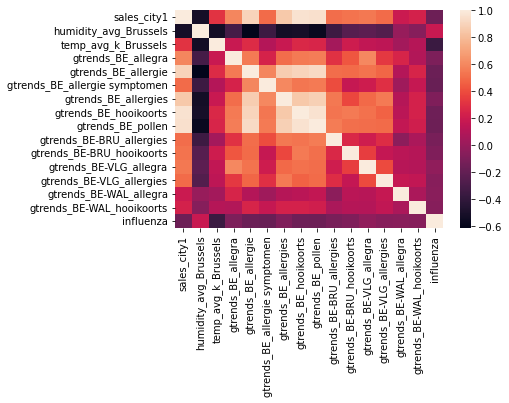

In [13]:
cols_vars = list(df_study.columns)[1:]

# calculate the correlation matrix on the numeric columns
corr = df_study[cols_vars].corr()

# plot the heatmap
sns.heatmap(corr)

Histogram of: sales_city1 



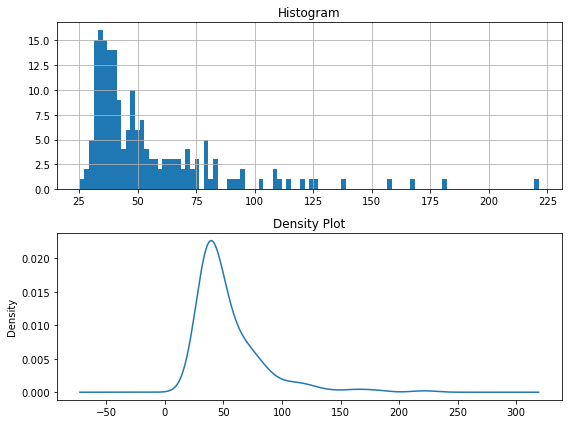

Histogram of: humidity_avg_Brussels 



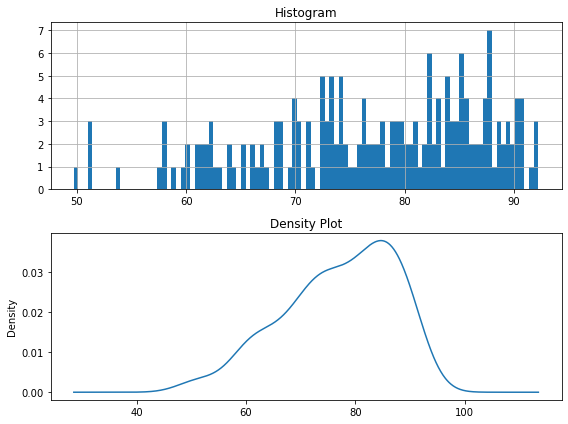

Histogram of: temp_avg_k_Brussels 



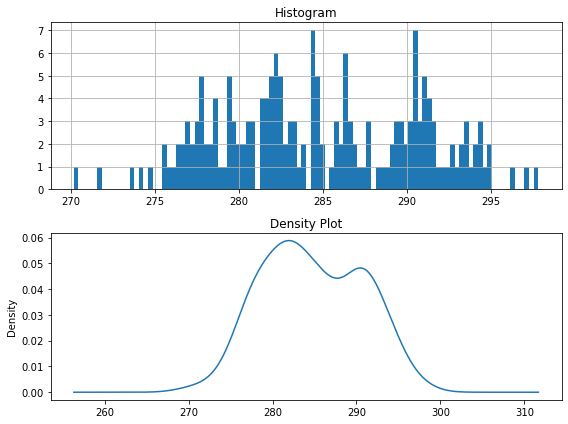

Histogram of: gtrends_BE_allegra 



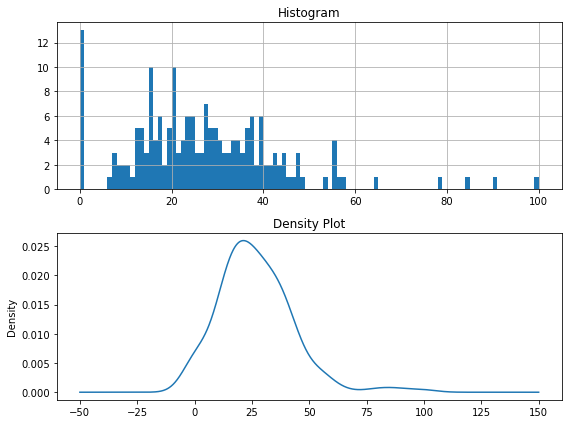

Histogram of: gtrends_BE_allergie 



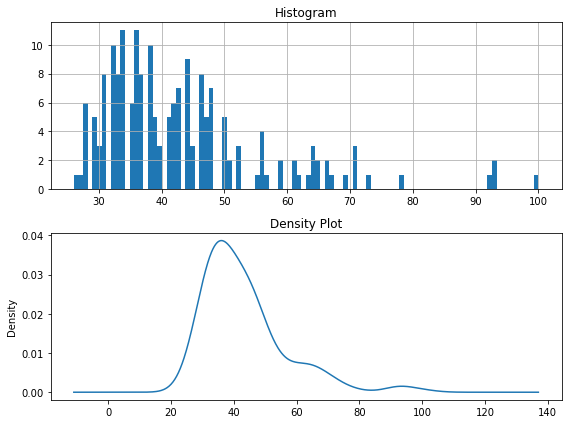

Histogram of: gtrends_BE_allergie symptomen 



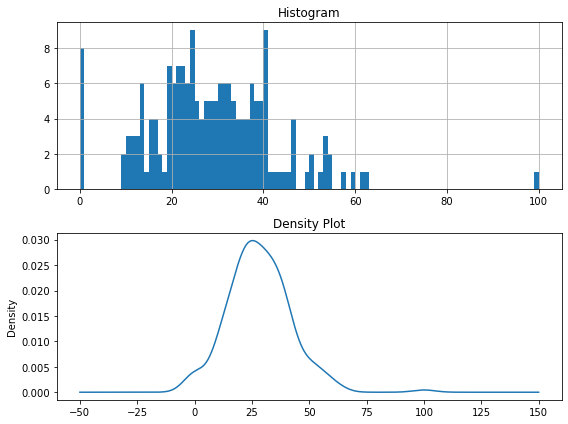

Histogram of: gtrends_BE_allergies 



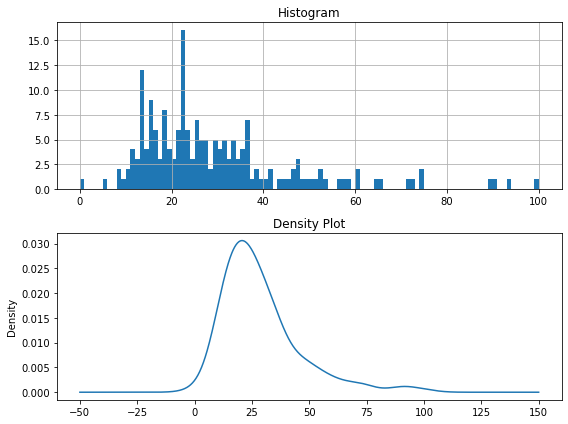

Histogram of: gtrends_BE_hooikoorts 



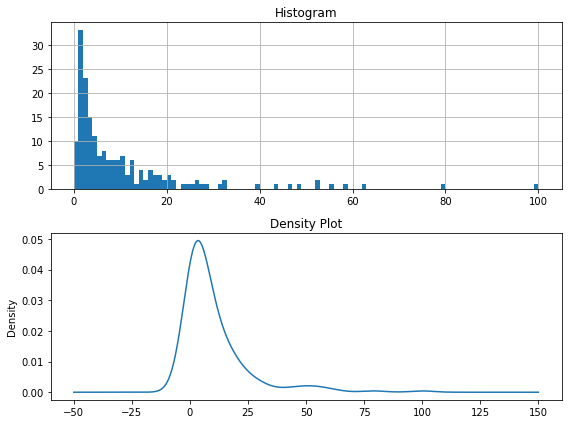

Histogram of: gtrends_BE_pollen 



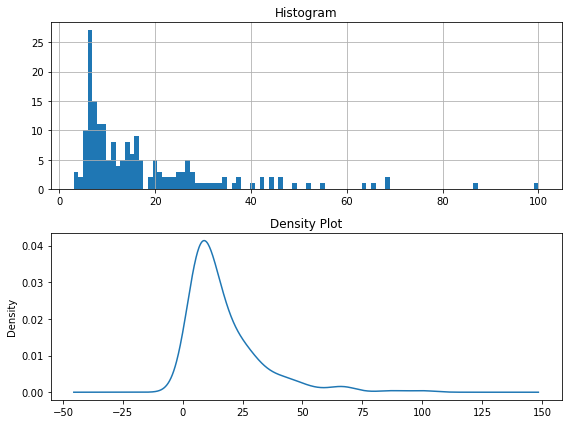

Histogram of: gtrends_BE-BRU_allergies 



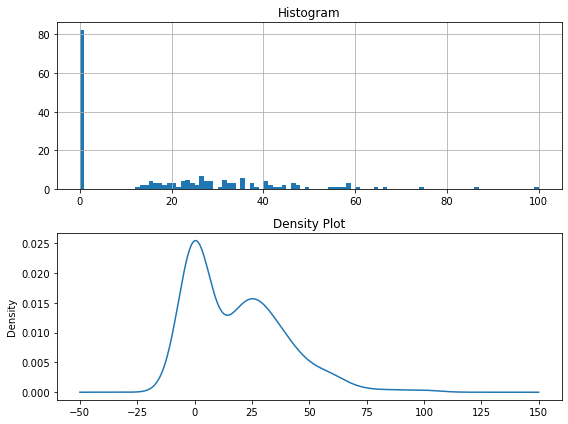

Histogram of: gtrends_BE-BRU_hooikoorts 



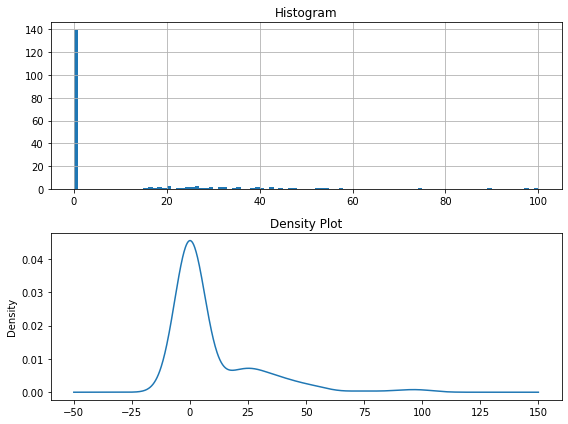

Histogram of: gtrends_BE-VLG_allegra 



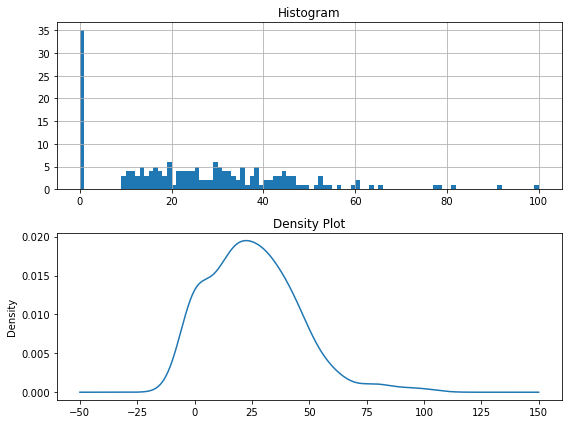

Histogram of: gtrends_BE-VLG_allergies 



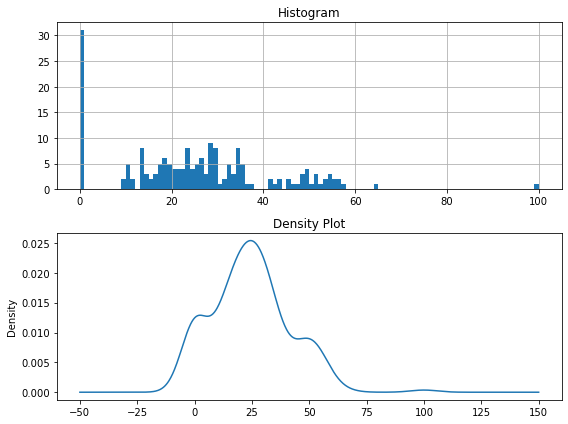

Histogram of: gtrends_BE-WAL_allegra 



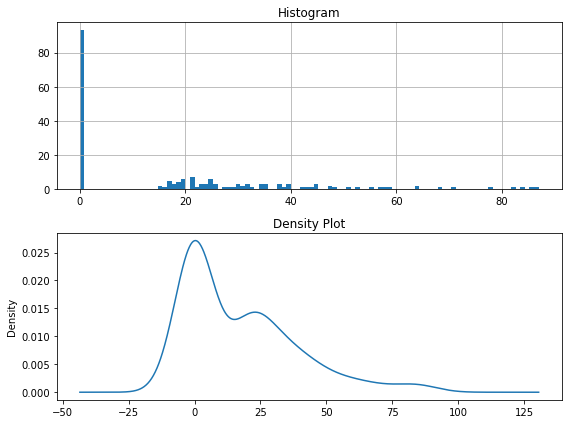

Histogram of: gtrends_BE-WAL_hooikoorts 



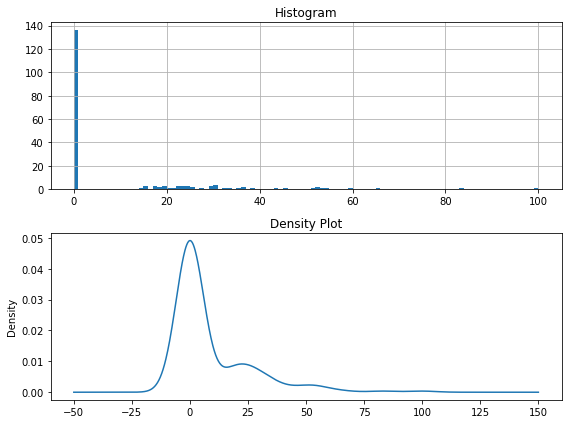

Histogram of: influenza 



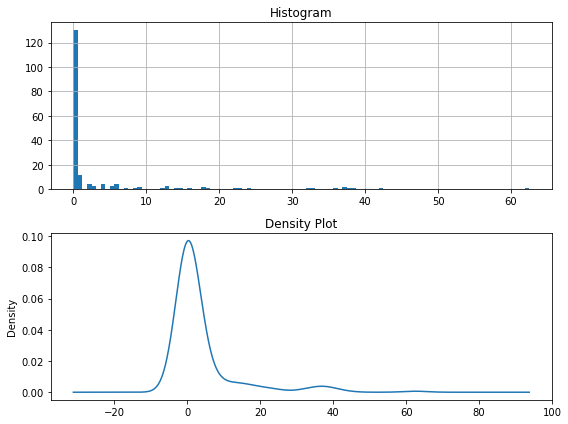

In [14]:
cols_vars = list(df_study.columns)[1:]


for col in cols_vars:
    print('Histogram of:', col, '\n')
    plt.figure(figsize=(8, 6))

    # Histograma
    plt.subplot(2, 1, 1)
    df_study[col].hist(bins=100)
    plt.title('Histogram')

    # Gráfico de densidad
    plt.subplot(2, 1, 2)
    df_study[col].plot(kind='density')
    plt.title('Density Plot')

    plt.tight_layout()
    plt.show()

Aquí tenemos los histogramas y gráficos de densidad por variable. 

Podemos ver por ejemplo que la mayoría de las ventas (variable target) se encuentran entre 25 y 50, formando una distribución similar a una chi cuadrado.

Podemos también ver algunos valores que podrían ser outliers, por ejemplo, valores cercanos a 100 en la variable gtrends_BE_pollen, este tipo de valores puede distorsionar las predicciones, así que probaremos a imputarlas para mejorar los resultados de los modelos.

### Gráficos de lineas de todas las variables

In [15]:
# Calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
tseries = {f"{x}": df_study.set_index("date")[x]for x in df_study.columns[1:]}

In [17]:
def ts_as_supervised(ts: pd.Series, n_lags: int) -> pd.DataFrame:
    ts_df = pd.concat([ts.shift(i) for i in range(n_lags, -1, -1)], axis=1)
    ts_df.columns = ['t-' + str(i) for i in list(reversed(range(n_lags)))[:-1]] + ['t', 't+1']
    ts_df['Date'] = ts.index.tolist()
    ts_df['Week'] = ts_df.Date.dt.isocalendar().week.astype("int")
    ts_df = ts_df.dropna().reset_index(drop=True).set_index("Date")
 
    return ts_df

def decomp_ts(dataframe, target):

    df_stl = pd.DataFrame({'data': dataframe[target].values}, index=pd.to_datetime(dataframe['date']))
    # Asegúrate de que 'sales_city1' contiene valores numéricos
    # Si no lo son, conviértelos a números

    df_stl.sort_index(inplace=True)

    #df_stl= df_stl.asfreq('7D')
    # Aplica seasonal_decompose a la serie temporal especificando la frecuencia
    result = seasonal_decompose(df_stl, model='multiplicative', period=52)  # Ajusta la frecuencia adecuada

    # Grafica el resultado
    #result.plot()
    print(target)
    plt.rcParams.update({'figure.figsize': (10,10)})
    result.plot().suptitle('Additive Decompose', fontsize=22)
    plt.show()
    
#training, testing, max_value = {}, {}, {}
#for k, ts in tseries.items():
#    # Using the last 6 months for testing
#    train = ts[ts.index < '2023-07-3']
#    test = ts[ts.index >= '2023-07-3']
 
    # Normalizing the data by the training mean value
#    max_value[k] = train.max()
#    train /= max_value[k]
#    test /= max_value[k]
 
    # Time series to tabular format
#    training[k] = training[k] = ts_as_supervised(train, 6)
#    testing[k] = ts_as_supervised(test, 6)
    
#train_df = pd.concat(training, axis=0)
#test_df = pd.concat(testing, axis=0)

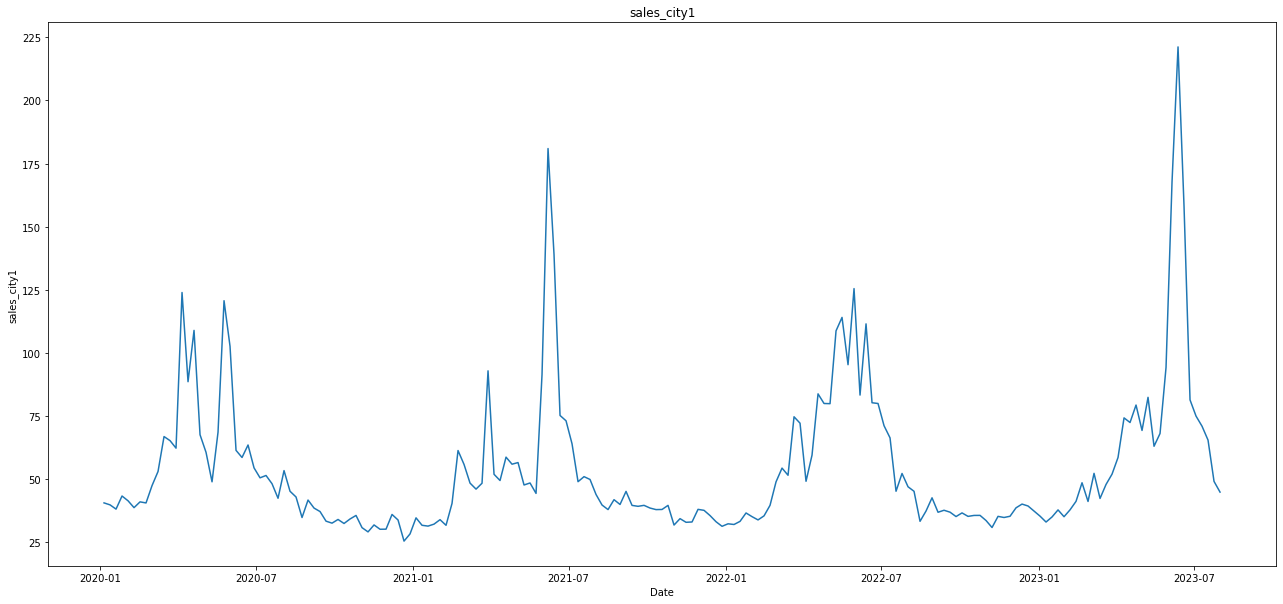

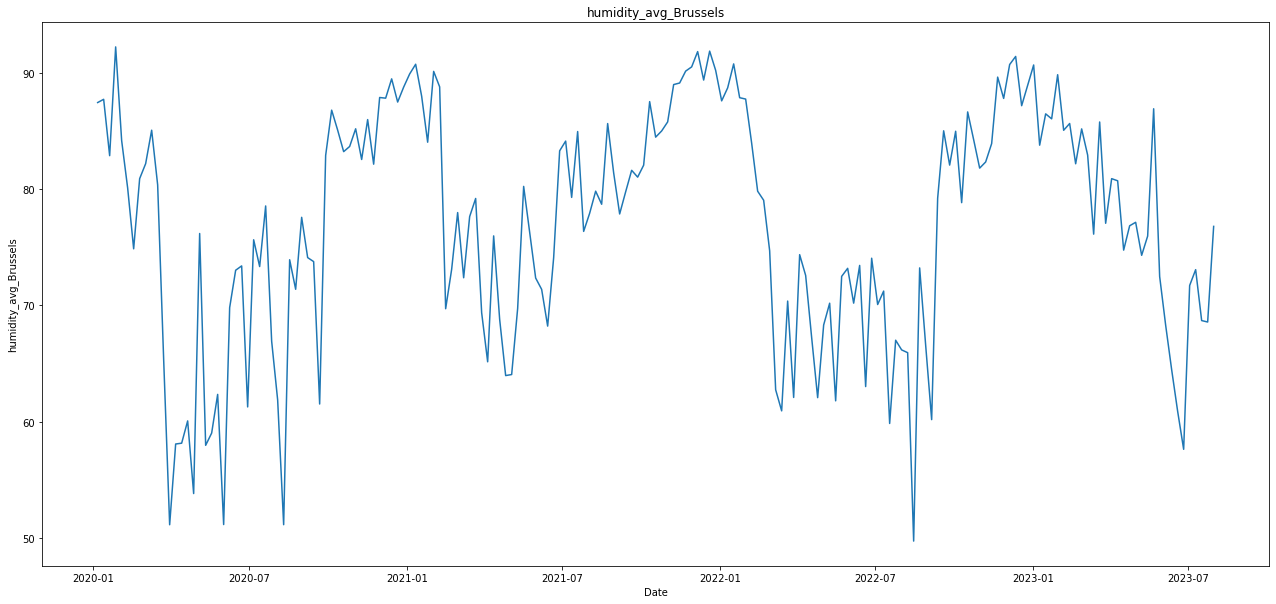

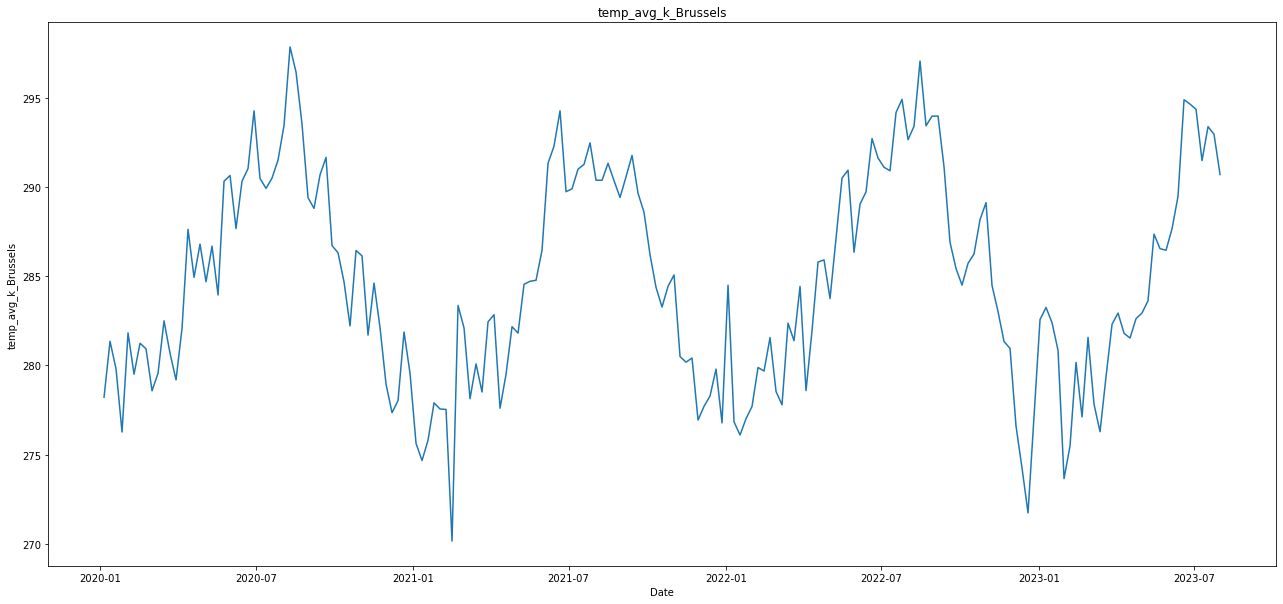

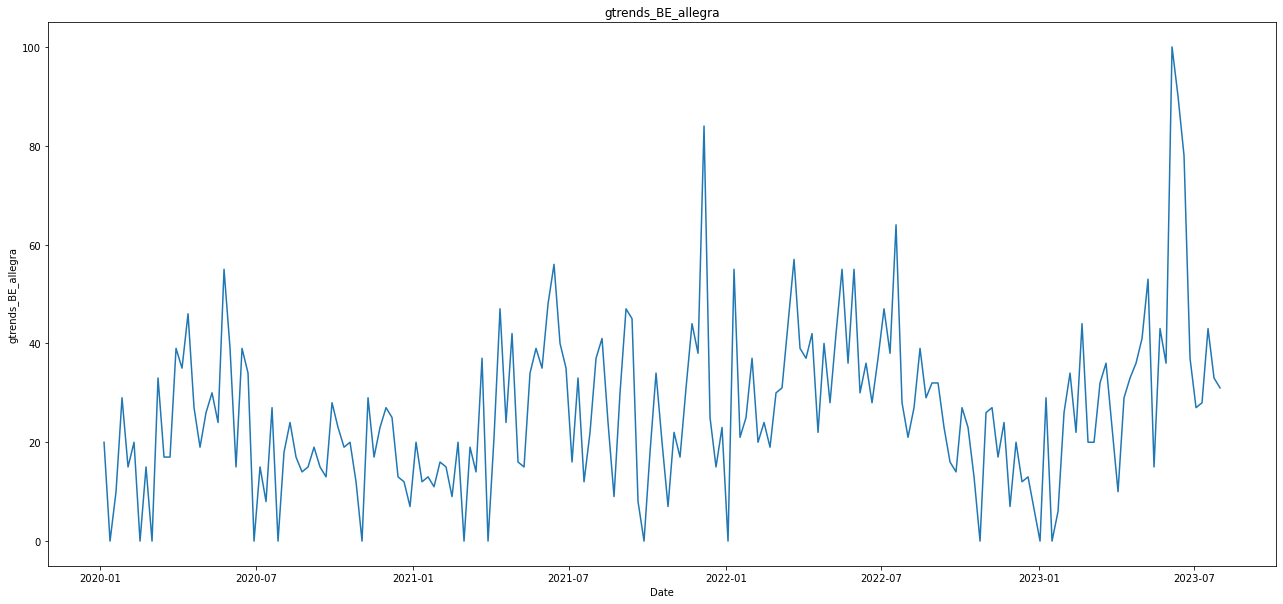

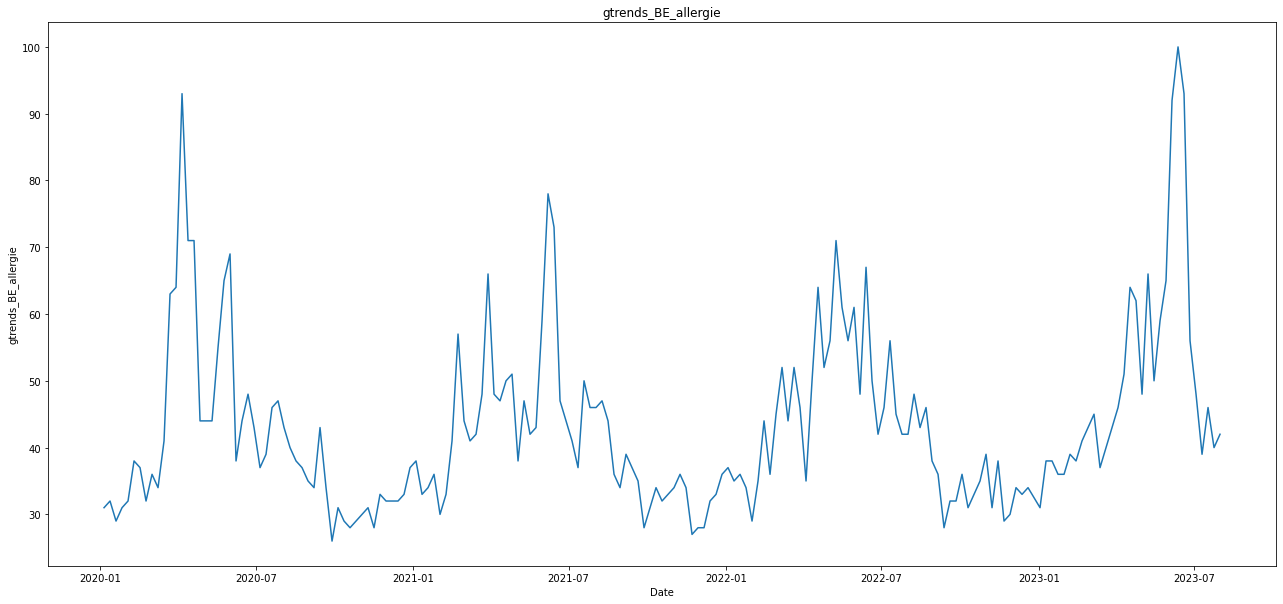

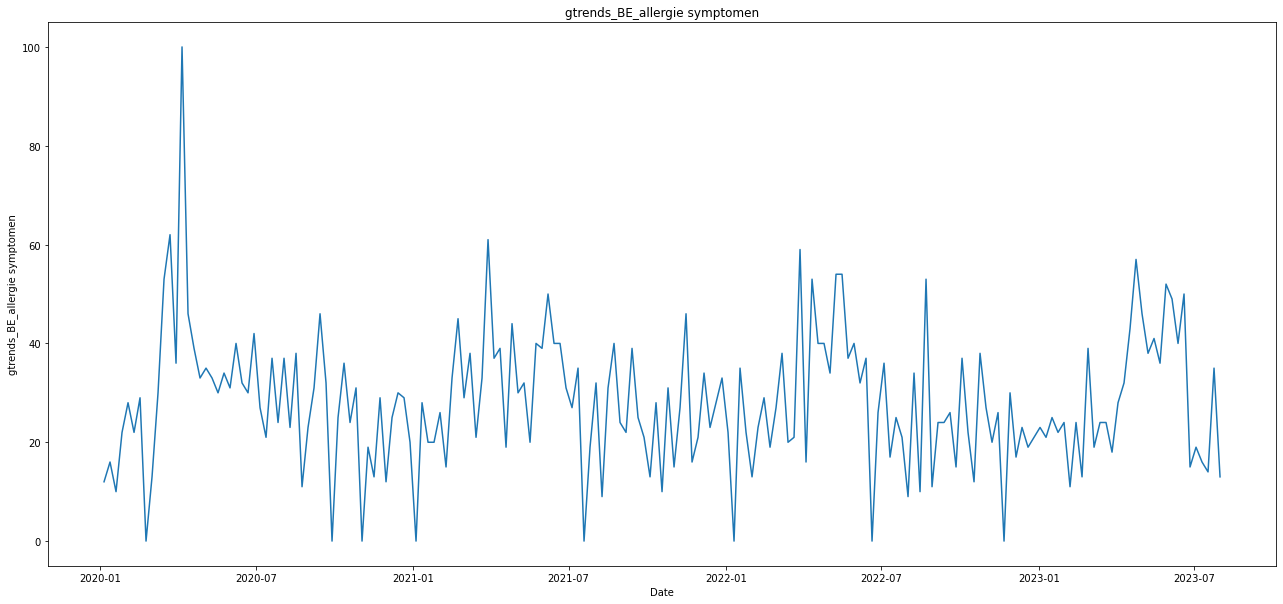

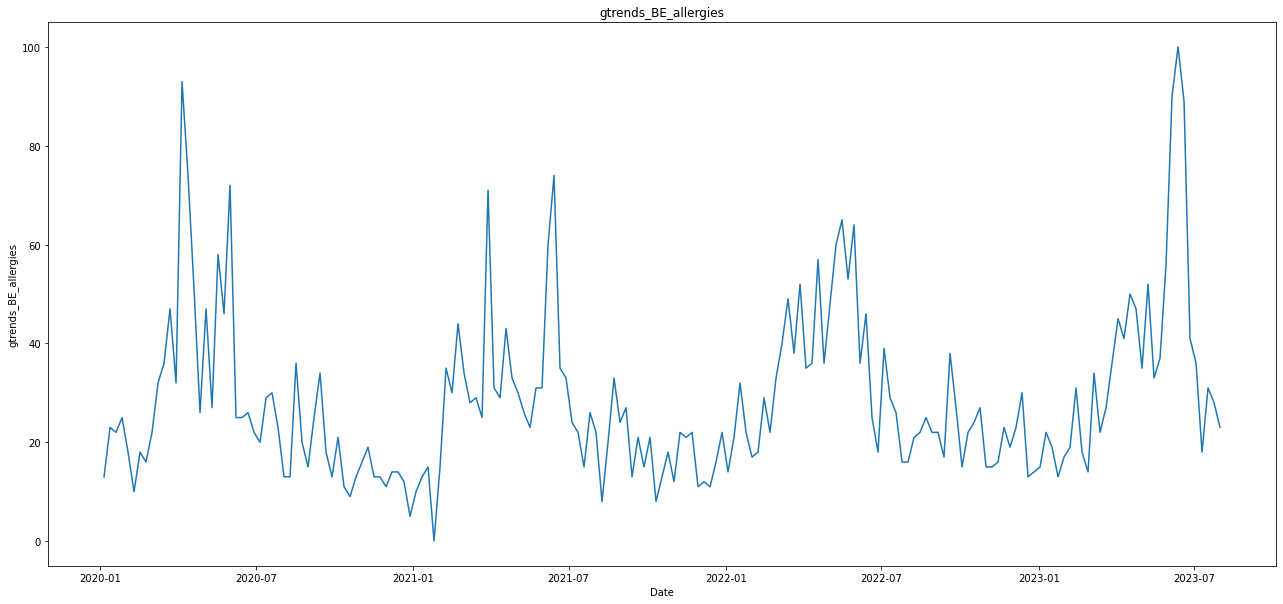

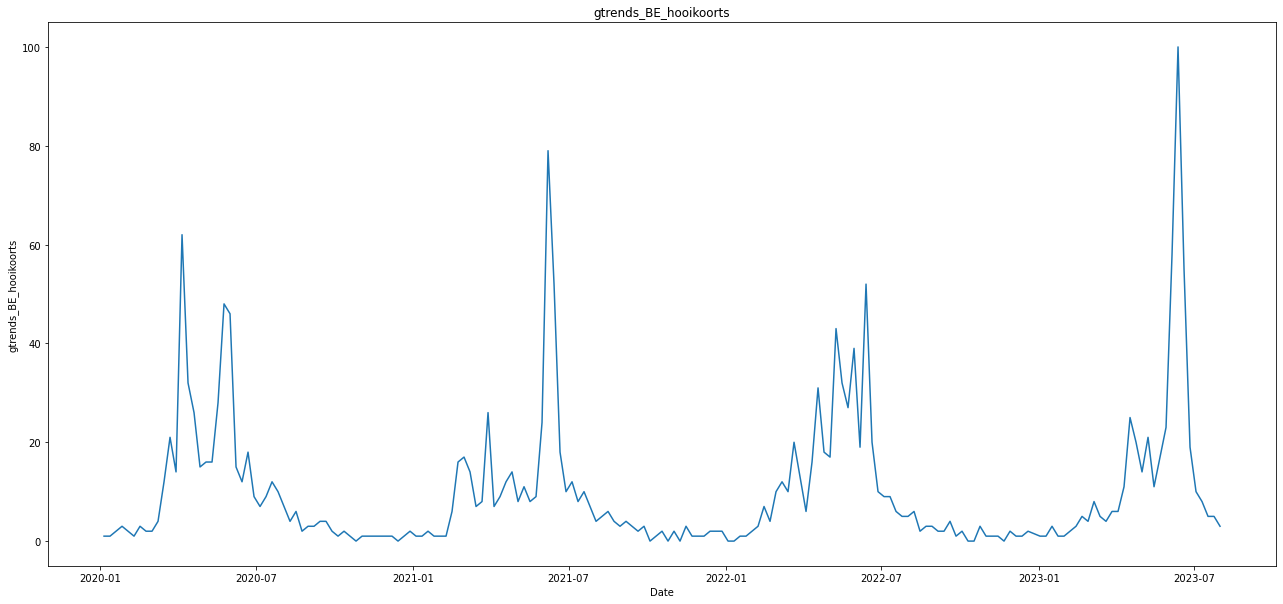

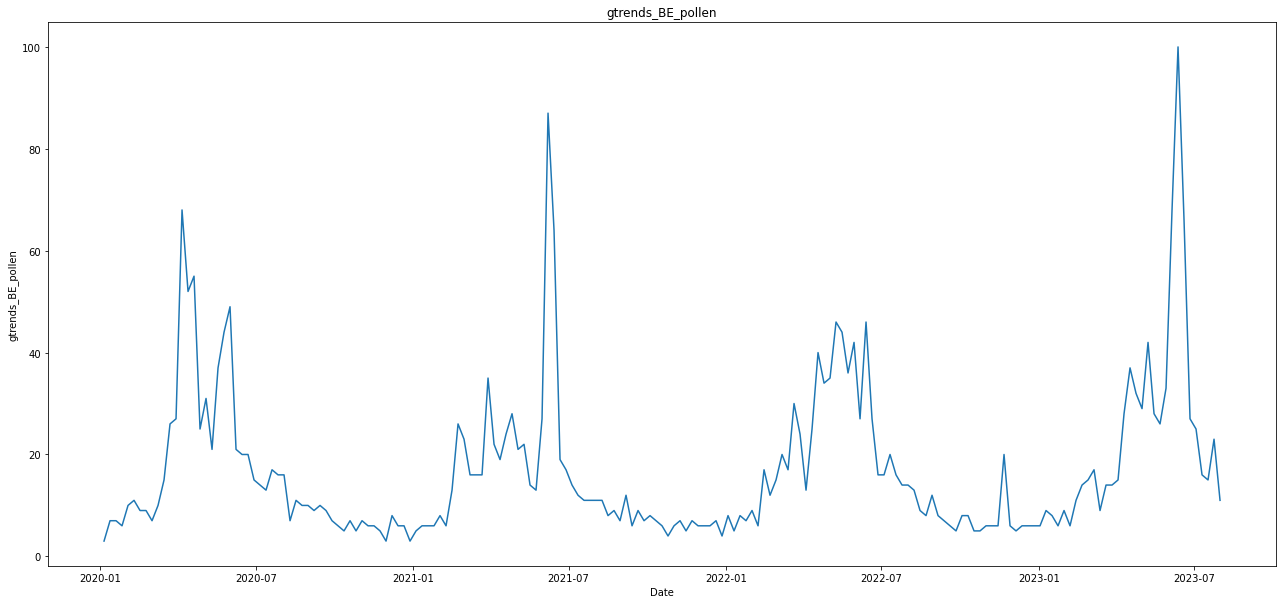

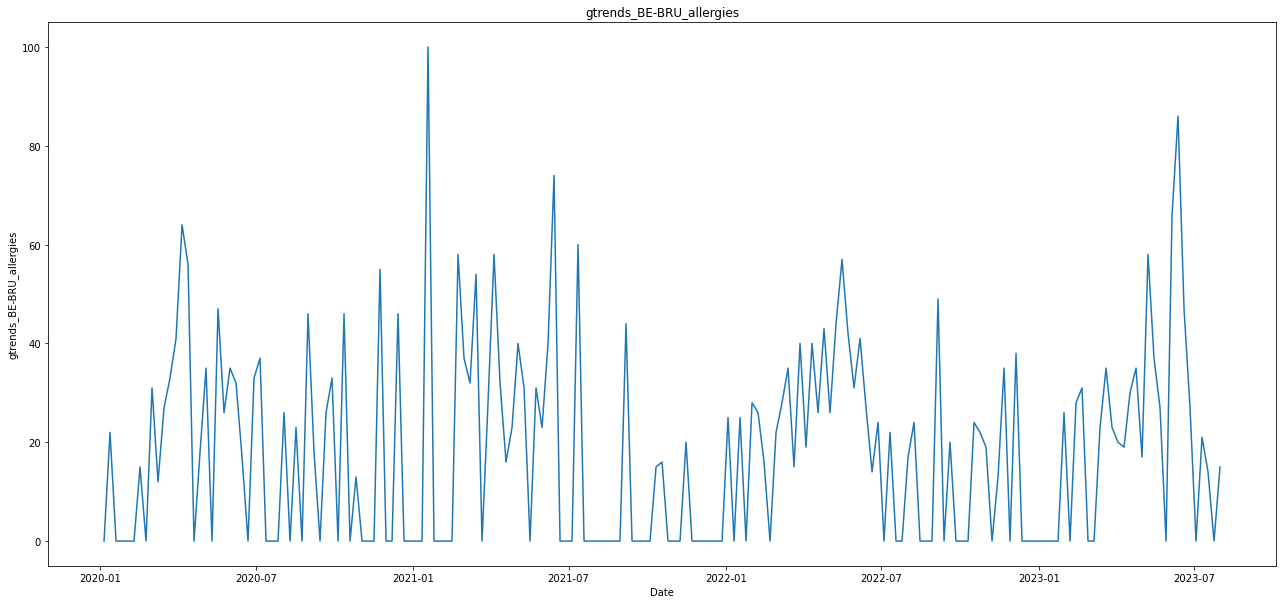

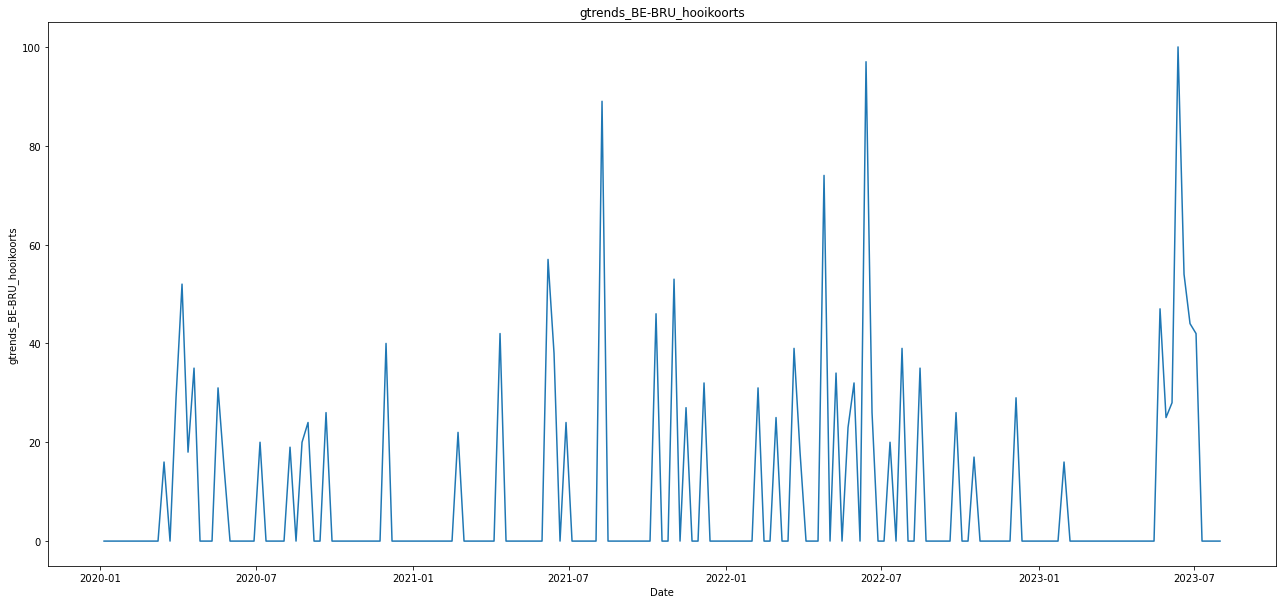

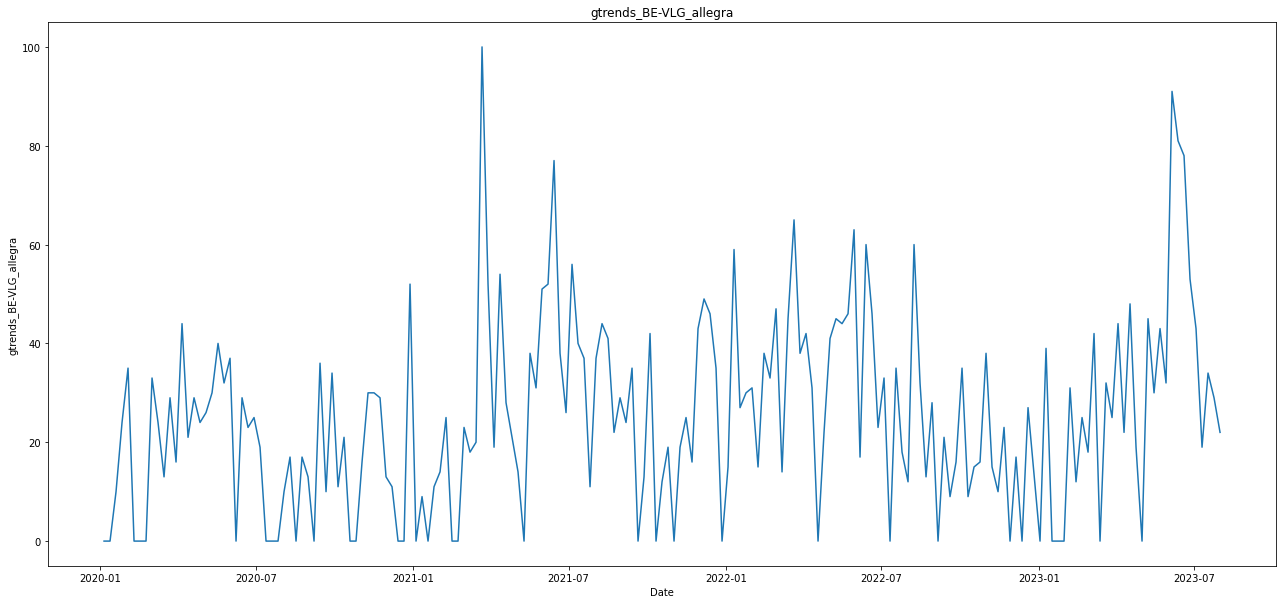

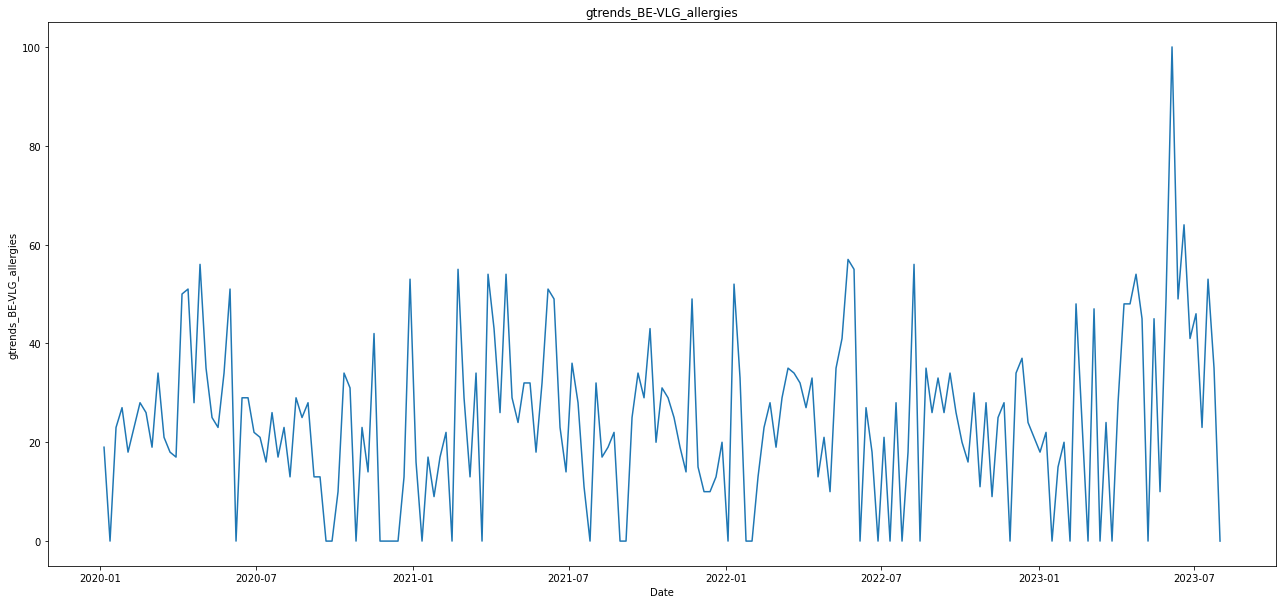

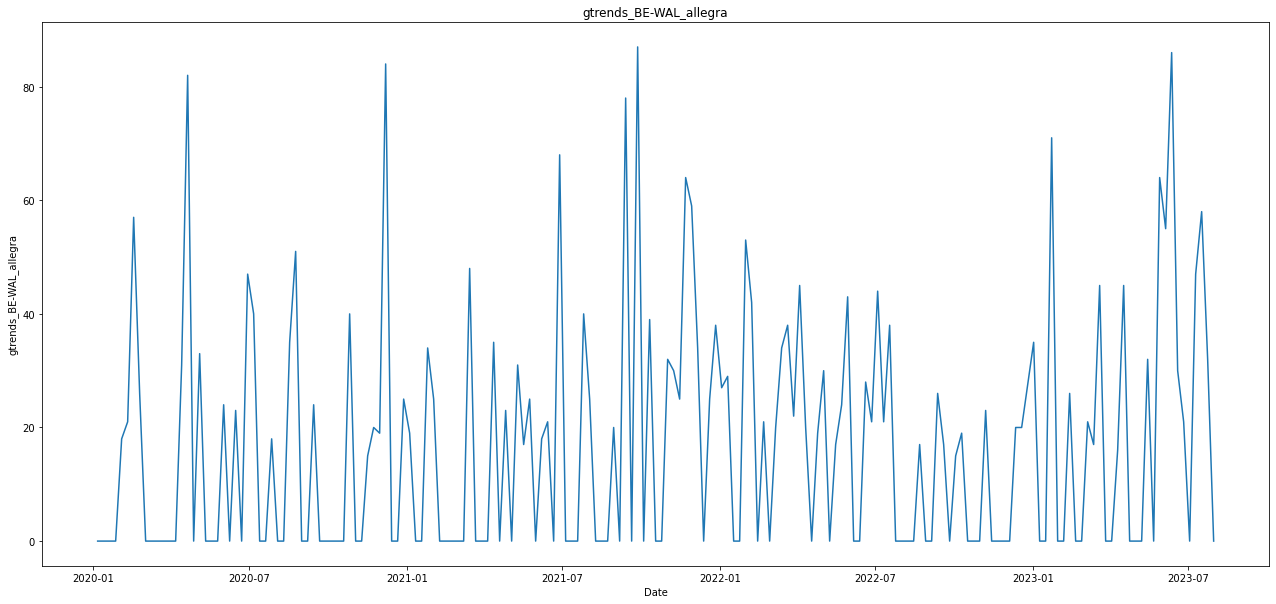

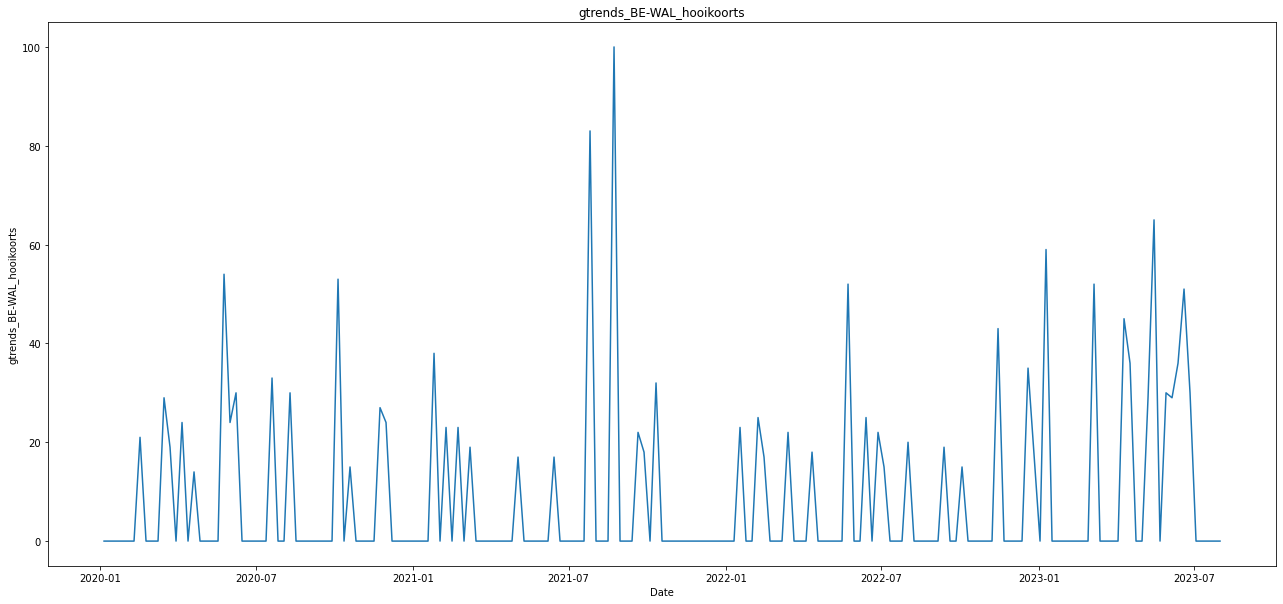

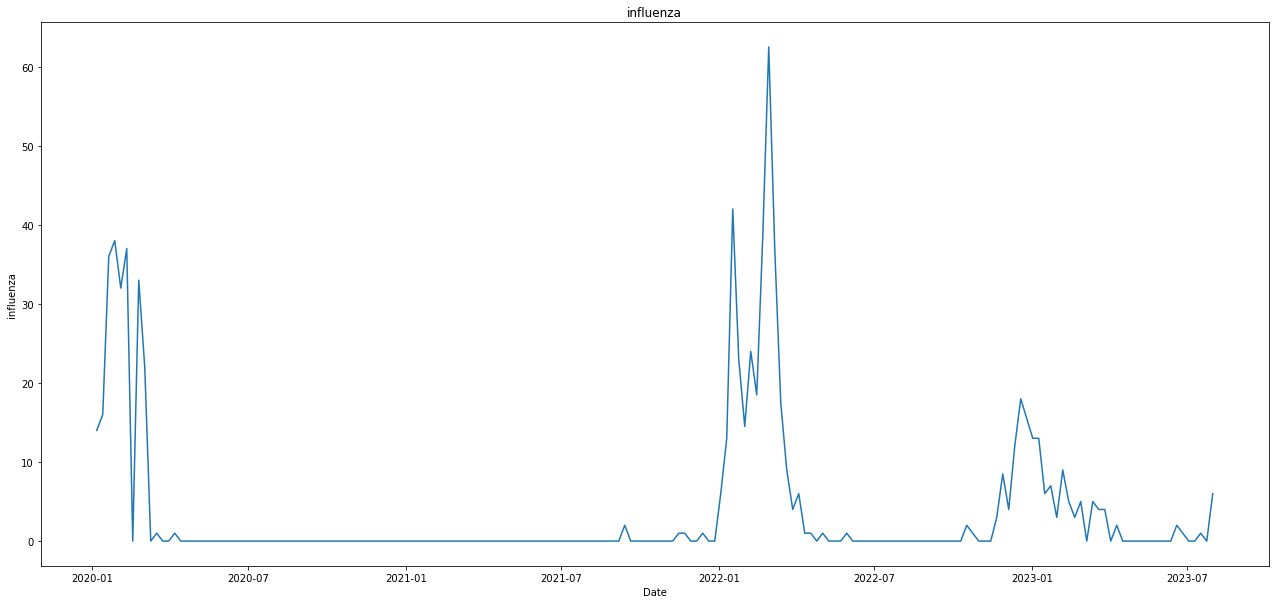

In [18]:
for key in tseries.keys():
    plt.figure(figsize=(22,10))
    plt.plot(tseries[key])
    plt.title(str(key))
    plt.xlabel("Date")
    plt.ylabel(str(key))
    plt.show()

Podemos ver una caída brusca de las ventas en los meses del inicio del covid en europa, coincidiendo con los confinamientos, puede ser buena idea obviar estos datos y no tenerlos en cuanta para entrenar. También podemos ver una estacionalidad clara de los datos, habiendo mayores ventas en la primera mitad del año y más bajas en la segunda mitad.

Sobre las variables de google trends, como por ejemplo temperatura o humedad medias de Bruselas, podemos ver también una estacionalidad clara, aunque a simple vista no se ven tendencia clara en esas variables.

sales_city1


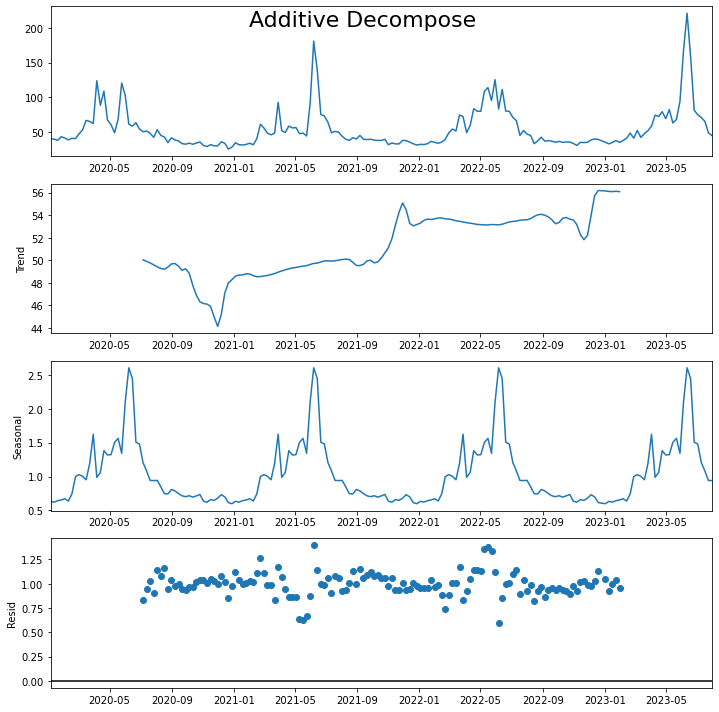

In [19]:
decomp_ts(df_study, 'sales_city1')

In [20]:
### Tengo dudas de cual sería el period adecuado, sería 52 porque tenemos datos semanales, o sería otro?

### Test Dicke-Fuller aumentado para comprobar estacionaridad

In [21]:
adf_test(tseries, 'sales_city1')

ADF Test Statistic -3.62
P Value 0.01
Time series is stationary, p value < 0.05.


### Gráficos de autocorrelación


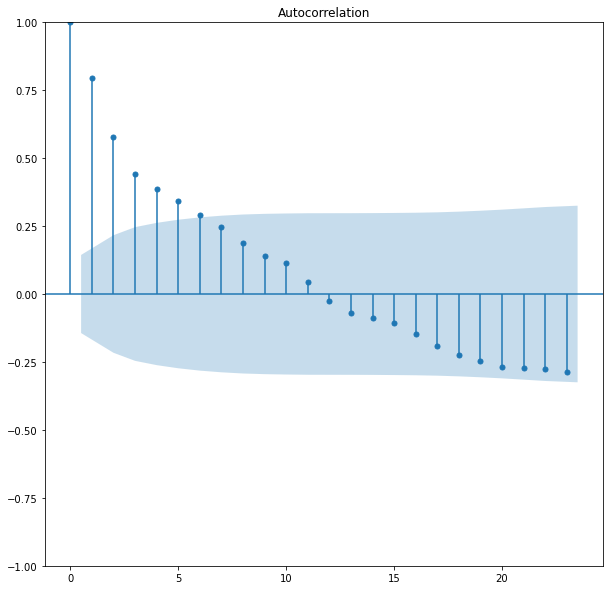

In [22]:
#Autocorrelation

plot_acf(tseries['sales_city1'])
plt.show()

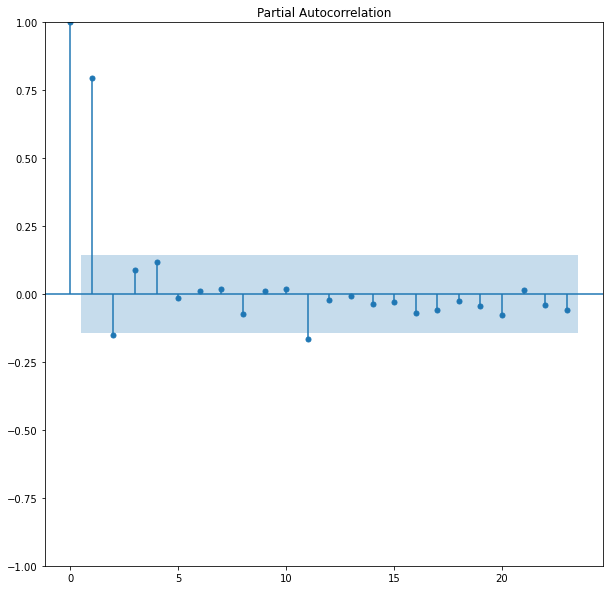

In [23]:
# Partial Autocorrelation

plot_pacf(tseries['sales_city1'], method='ywm')
plt.show()

### Gráfico cambios de tendencia

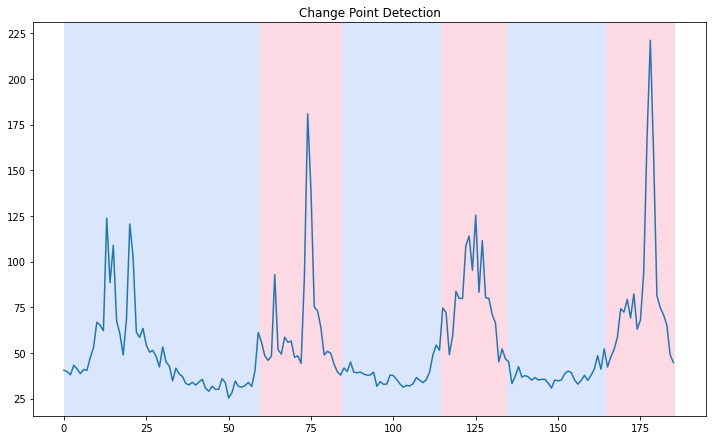

In [24]:
# Model Inputs
points = np.array(tseries['sales_city1'])

algo = rpt.Window(model="l2", width=30)
algo.fit(points)
result = algo.predict(n_bkps=5)

rpt.show.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection')
plt.show()

(<Figure size 720x144 with 1 Axes>, [<AxesSubplot:>])

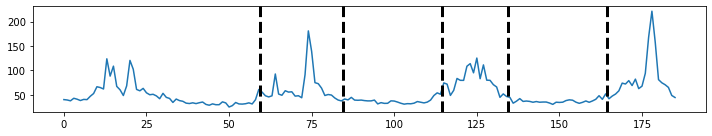

In [25]:
rpt.display(points, [], result)

# Entrenamiento modelos

# ARIMA

In [26]:
ts_data = tseries['sales_city1']
ts_data = ts_data.asfreq('W-MON')

ts_data_train = ts_data[:'2023-05-22']
ts_data_test = ts_data['2023-05-29':'2023-06-26']

def arima_fit(ts_data_train):

    # Ajustamos el modelo ARIMA a la serie temporal
    model = ARIMA(ts_data_train, order=(2, 1, 5))  # Parámetros p, d, q del modelo ARIMA
    arima_results = model.fit()

    # Realizamos el pronóstico (forecast) de 30 periodos hacia adelante
    forecast_arima = arima_results.forecast(steps=5)
    
    return model, forecast_arima

model_arima1, forecast_arima1 = arima_fit(ts_data_train)

In [27]:
gf_metrics_test = pd.DataFrame(columns=['MSE', 'MAE', 'RMSE', 'MAPE'])
#gf_metrics.index = ['ARIMA', 'SARIMA', 'XGBOOST', 'LGBM', 'PROPHET']

In [28]:
mse, mae, rmse, mape = print_fit_metrics(ts_data_test, forecast_arima1)

gf_metrics_test.loc[0, 'MSE'] = mse
gf_metrics_test.loc[0, 'MAE'] = mae
gf_metrics_test.loc[0, 'RMSE'] = rmse
gf_metrics_test.loc[0, 'MAPE'] = mape
gf_metrics_test.index = ['ARIMA']
gf_metrics_test

Error Cuadrático Medio (MSE): 8563.33
Error Absoluto Medio (MAE): 76.74
Raíz del Error Cuadrático Medio (RMSE): 92.54
Error Porcentual Absoluto Medio (MAPE): 46.06%


,MSE,MAE,RMSE,MAPE
ARIMA,8563.330217,76.744002,92.538264,46.061401


# SARIMA

In [29]:
def sarima_fit(ts_data_train, pred_ini, pred_last):
    
    model = SARIMAX(ts_data_train, order=(2, 1, 5), seasonal_order=(1, 0, 1, 12))
    sarima_results = model.fit()
    forecast_sarima = sarima_results.get_prediction(start=pd.to_datetime(pred_ini),end=pd.to_datetime(pred_last), dynamic=False)

    return model, forecast_sarima

model_sarima1, forecast_sarima1 = sarima_fit(ts_data_train, '2023-05-29', '2023-06-26')
forecast_sarima1.predicted_mean

C:\Users\tomas\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2023-05-29    66.599391
2023-06-05    68.334429
2023-06-12    66.237973
2023-06-19    68.294071
2023-06-26    68.404924
Freq: W-MON, Name: predicted_mean, dtype: float64

In [30]:
mse, mae, rmse, mape = print_fit_metrics(ts_data_test, forecast_sarima1.predicted_mean)

gf_metrics_test.loc[1, 'MSE'] = mse
gf_metrics_test.loc[1, 'MAE'] = mae
gf_metrics_test.loc[1, 'RMSE'] = rmse
gf_metrics_test.loc[1, 'MAPE'] = mape
gf_metrics_test.index = ['ARIMA', 'SARIMA']
gf_metrics_test

Error Cuadrático Medio (MSE): 8574.89
Error Absoluto Medio (MAE): 76.91
Raíz del Error Cuadrático Medio (RMSE): 92.60
Error Porcentual Absoluto Medio (MAPE): 46.25%


,MSE,MAE,RMSE,MAPE
ARIMA,8563.330217,76.744002,92.538264,46.061401
SARIMA,8574.889658,76.913083,92.6007,46.248551


# XGBOOST

In [31]:
# Asegúrate de tener la columna 'fecha' como índice y ordena los datos por fecha si es necesario

data_xg = df_study.copy()
data_xg['fecha'] = pd.to_datetime(data_xg['date'])
data_xg = data_xg.set_index('fecha').sort_index()

# Preparar características (lag features) y variable objetivo para el modelo
lags = 5  # Número de retrasos pasados a considerar como características
for i in range(1, lags + 1):
    data_xg[f'lag_{i}'] = data_xg['sales_city1'].shift(i)

    data_xg.dropna(inplace=True)  # Eliminar filas con valores NaN generados por los retrasos

data_xg.dropna(inplace=True)  # Eliminar filas con valores NaN generados por los retrasos

data_xg['fecha'] = data_xg.index
data_xg['quarter'] = data_xg['fecha'].dt.quarter
data_xg['month'] = data_xg['fecha'].dt.month
data_xg['year'] = data_xg['fecha'].dt.year
data_xg['dayofyear'] = data_xg['fecha'].dt.dayofyear
data_xg['dayofmonth'] = data_xg['fecha'].dt.day
data_xg['weekofyear'] = data_xg['fecha'].dt.weekofyear

ts_data_xg_train = data_xg[:'2023-05-22']
ts_data_xg_test = data_xg['2023-05-27':'2023-06-26']


    
ts_data_xg_test.iloc[1, 17] = nan
ts_data_xg_test.iloc[2, 17:19] = nan
ts_data_xg_test.iloc[3, 17:20] = nan
ts_data_xg_test.iloc[4, 17:21] = nan

# Dividir datos en características (X) y variable objetivo (y)
X_train, y_train = ts_data_xg_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']], ts_data_xg_train['sales_city1']
X_test, y_test = ts_data_xg_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']], ts_data_xg_test['sales_city1']


C:\Users\tomas\AppData\Local\Temp\ipykernel_49416\423972751.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_xg['weekofyear'] = data_xg['fecha'].dt.weekofyear


In [32]:
def fit_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred_xg = model.predict(X_test)
    
    return model, y_pred_xg

model_xgb1, y_pred_xg1 = fit_xgboost(X_train, y_train)
y_pred_xg1

array([59.995007, 90.158195, 87.82725 , 74.6112  , 74.4469  ],
      dtype=float32)

In [33]:
xgb_models = {}
xgb_predict = []

for t in range(0,5):
    # Inicializar y entrenar el modelo XGBoost
    model = xgb.XGBRegressor(n_estimators=300, random_state=42)
    model.fit(X_train.iloc[:, t:], y_train)
 
    xgb_models.update({f'model_{t}': model})


    # Realizar predicciones en el conjunto de prueba
    y_pred_xg_t = model.predict(X_test.iloc[t, t:].values.reshape(1, -1))

    xgb_predict.append(y_pred_xg_t[0])
    

mse = mean_squared_error(y_test, xgb_predict)
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')

Error Cuadrático Medio (MSE): 5911.13


In [34]:
mse, mae, rmse, mape = print_fit_metrics(ts_data_test, xgb_predict)

gf_metrics_test.loc[2, 'MSE'] = mse
gf_metrics_test.loc[2, 'MAE'] = mae
gf_metrics_test.loc[2, 'RMSE'] = rmse
gf_metrics_test.loc[2, 'MAPE'] = mape
gf_metrics_test.index = ['ARIMA', 'SARIMA', 'XGBOOST']
gf_metrics_test

Error Cuadrático Medio (MSE): 5911.13
Error Absoluto Medio (MAE): 64.64
Raíz del Error Cuadrático Medio (RMSE): 76.88
Error Porcentual Absoluto Medio (MAPE): 39.53%


,MSE,MAE,RMSE,MAPE
ARIMA,8563.330217,76.744002,92.538264,46.061401
SARIMA,8574.889658,76.913083,92.6007,46.248551
XGBOOST,5911.13356,64.640826,76.883897,39.526259


# LGBM

In [35]:
def fit_lgbm(X_train, y_train):
    model = lgb.LGBMRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred_lgb = model.predict(X_test)
    
    return model, y_pred_lgb

model_lgb1, y_pred_lgb1 = fit_lgbm(X_train, y_train)
y_pred_lgb1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 161, number of used features: 11
[LightGBM] [Info] Start training from score 51.076401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

array([95.81875048, 58.8377183 , 65.2385113 , 57.08408316, 52.79969171])

In [36]:
lgb_models = {}
lgb_predict = []

for t in range(0,5):
    # Inicializar y entrenar el modelo XGBoost
    lgb_model = lgb.LGBMRegressor(n_estimators=300, random_state=42)
    lgb_model.fit(X_train.iloc[:, t:], y_train)
 
    lgb_models.update({f'model_{t}': lgb_model})


    # Realizar predicciones en el conjunto de prueba
    y_pred_lgb_t = lgb_model.predict(X_test.iloc[t, t:].values.reshape(1, -1))

    lgb_predict.append(y_pred_lgb_t[0])
    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 161, number of used features: 11
[LightGBM] [Info] Start training from score 51.076401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [37]:
mse, mae, rmse, mape = print_fit_metrics(ts_data_test, lgb_predict)

gf_metrics_test.loc[3, 'MSE'] = mse
gf_metrics_test.loc[3, 'MAE'] = mae
gf_metrics_test.loc[3, 'RMSE'] = rmse
gf_metrics_test.loc[3, 'MAPE'] = mape
gf_metrics_test.index = ['ARIMA', 'SARIMA', 'XGBOOST', 'LGBM']
gf_metrics_test

Error Cuadrático Medio (MSE): 5679.27
Error Absoluto Medio (MAE): 56.24
Raíz del Error Cuadrático Medio (RMSE): 75.36
Error Porcentual Absoluto Medio (MAPE): 30.44%


,MSE,MAE,RMSE,MAPE
ARIMA,8563.330217,76.744002,92.538264,46.061401
SARIMA,8574.889658,76.913083,92.6007,46.248551
XGBOOST,5911.13356,64.640826,76.883897,39.526259
LGBM,5679.26594,56.238245,75.360905,30.442422


In [38]:
def fit_prophet(ts_data_train):
    m = Prophet()
    prophet_input = pd.DataFrame()


    prophet_input['ds'] = ts_data_train.index
    prophet_input['y'] = ts_data_train.values

    #ts_data['2023-07-03':'2023-07-31']

    m.fit(prophet_input)

    future = m.make_future_dataframe(periods=5, freq='W')
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    prophet_pred = forecast['yhat'].iloc[forecast.shape[0]-5:,]
    
    return m, prophet_pred

model_prophet1, prophet_pred1 = fit_prophet(ts_data_train)

20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
mse, mae, rmse, mape = print_fit_metrics(ts_data_test, prophet_pred1)

gf_metrics_test.loc[4, 'MSE'] = mse
gf_metrics_test.loc[4, 'MAE'] = mae
gf_metrics_test.loc[4, 'RMSE'] = rmse
gf_metrics_test.loc[4, 'MAPE'] = mape
gf_metrics_test.index = ['ARIMA', 'SARIMA', 'XGBOOST', 'LGBM', 'PROPHET']
gf_metrics_test

C:\Users\tomas\AppData\Local\Temp\ipykernel_49416\2293960722.py:22: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100


Error Cuadrático Medio (MSE): 4233.60
Error Absoluto Medio (MAE): 50.16
Raíz del Error Cuadrático Medio (RMSE): 65.07
Error Porcentual Absoluto Medio (MAPE): nan%


,MSE,MAE,RMSE,MAPE
ARIMA,8563.330217,76.744002,92.538264,46.061401
SARIMA,8574.889658,76.913083,92.6007,46.248551
XGBOOST,5911.13356,64.640826,76.883897,39.526259
LGBM,5679.26594,56.238245,75.360905,30.442422
PROPHET,4233.597814,50.155626,65.066103,NaN


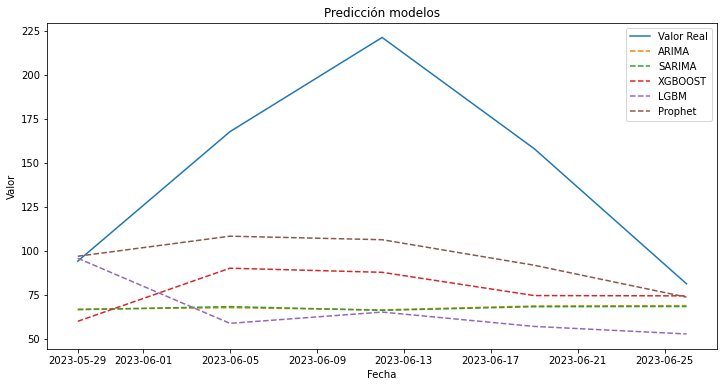

In [40]:
# Visualizar las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(ts_data_xg_test.index, y_test, label='Valor Real')
plt.plot(ts_data_xg_test.index, forecast_arima1, label='ARIMA', linestyle='dashed')
#plt.plot(ts_data_xg_test.index, forecast_sarima.values, label='Predicción', linestyle='dashed')
plt.plot(forecast_sarima1.predicted_mean.index, forecast_sarima1.predicted_mean, label='SARIMA', linestyle='dashed')
plt.plot(ts_data_xg_test.index, y_pred_xg1, label='XGBOOST', linestyle='dashed')
plt.plot(ts_data_xg_test.index, y_pred_lgb1, label='LGBM', linestyle='dashed')
plt.plot(ts_data_xg_test.index, prophet_pred1, label='Prophet', linestyle='dashed')

plt.title('Predicción modelos')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [41]:
ensemb_inp_adap = pd.DataFrame()
#ensemb_inp_adap['ARIMA'] = forecast_arima
#ensemb_inp_adap['SARIMA'] = forecast_sarima.predicted_mean
ensemb_inp_adap['XGBOOST'] = xgb_predict
ensemb_inp_adap['LGBM'] = lgb_predict
ensemb_inp_adap['Prophet'] = prophet_pred1.values

ensemb_inp_adap

,XGBOOST,LGBM,Prophet
0,59.995007,95.818750,96.946448
1,99.190987,84.822643,108.348654
2,95.837227,89.063910,106.339893
3,68.947197,94.336255,91.835245
4,75.261658,80.491065,73.730871


Aplha: 0.001
Error Cuadrático Medio (MSE): 1294.24
Error Absoluto Medio (MAE): 32.61
Raíz del Error Cuadrático Medio (RMSE): 35.98
Error Porcentual Absoluto Medio (MAPE): 27.25%


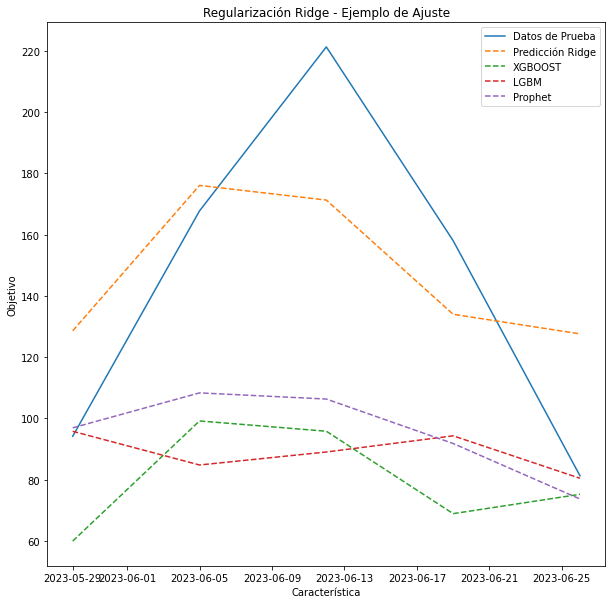

------------
Aplha: 0.01
Error Cuadrático Medio (MSE): 1294.24
Error Absoluto Medio (MAE): 32.61
Raíz del Error Cuadrático Medio (RMSE): 35.98
Error Porcentual Absoluto Medio (MAPE): 27.25%


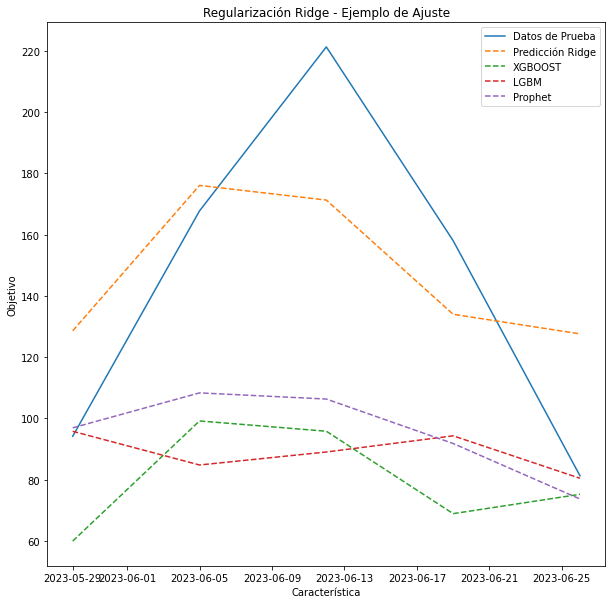

------------
Aplha: 0.1
Error Cuadrático Medio (MSE): 1294.24
Error Absoluto Medio (MAE): 32.61
Raíz del Error Cuadrático Medio (RMSE): 35.98
Error Porcentual Absoluto Medio (MAPE): 27.25%


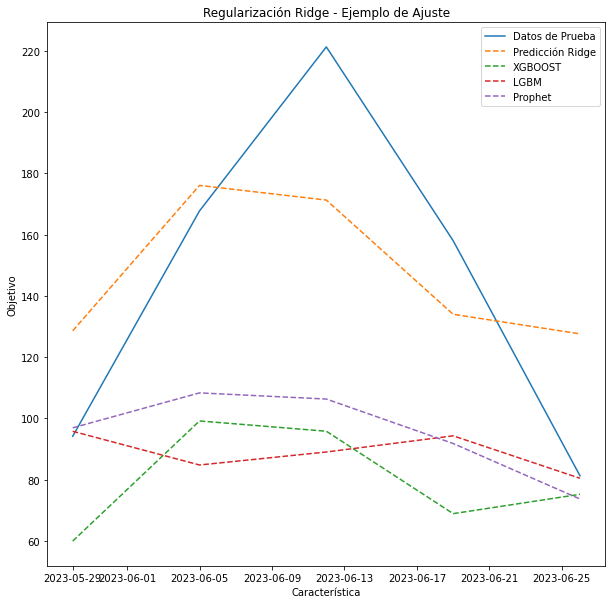

------------
Aplha: 0.5
Error Cuadrático Medio (MSE): 1294.24
Error Absoluto Medio (MAE): 32.61
Raíz del Error Cuadrático Medio (RMSE): 35.98
Error Porcentual Absoluto Medio (MAPE): 27.25%


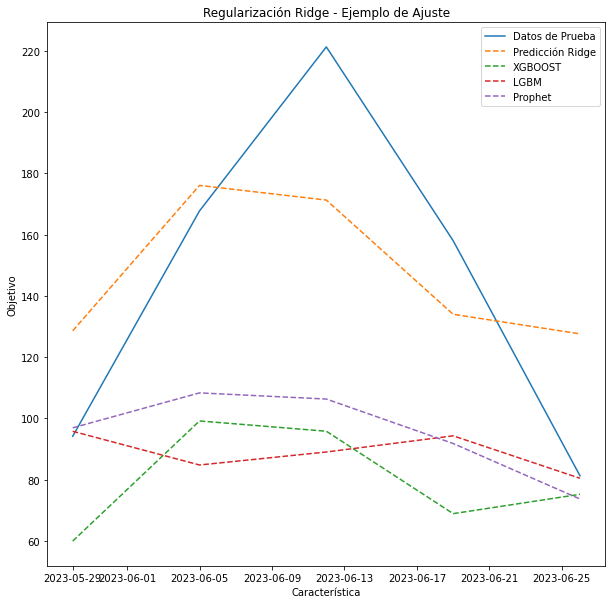

------------
Aplha: 1
Error Cuadrático Medio (MSE): 1294.24
Error Absoluto Medio (MAE): 32.61
Raíz del Error Cuadrático Medio (RMSE): 35.98
Error Porcentual Absoluto Medio (MAPE): 27.25%


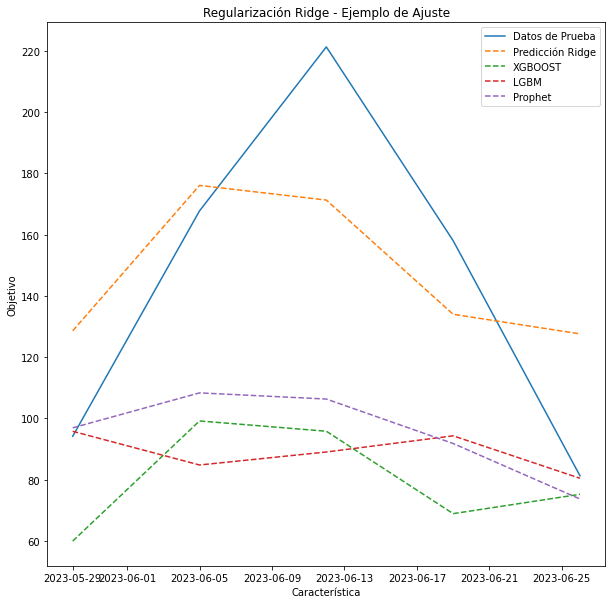

------------
Aplha: 2
Error Cuadrático Medio (MSE): 1294.24
Error Absoluto Medio (MAE): 32.61
Raíz del Error Cuadrático Medio (RMSE): 35.98
Error Porcentual Absoluto Medio (MAPE): 27.25%


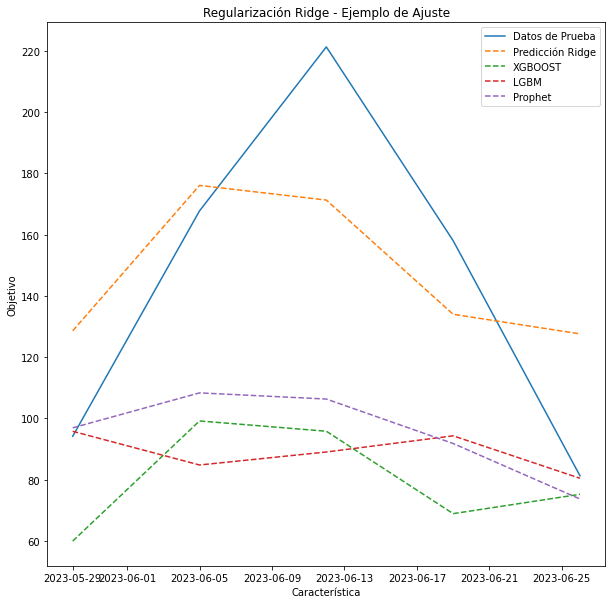

------------


In [42]:
for alpha in (0.001, 0.01, 0.1, 0.5, 1, 2):
    
    print('Aplha:', alpha)
    
    # Inicializar el modelo Ridge
    ridge = Ridge(alpha=0.001, fit_intercept=False, solver='lbfgs', positive=True)

    # Entrenar el modelo
    ridge.fit(ensemb_inp_adap, y_test)

    # Realizar predicciones en el conjunto de prueba
    y_pred_ridge = ridge.predict(ensemb_inp_adap)

        
    print_fit_metrics(y_test, y_pred_ridge)

    # Visualizar el ajuste del modelo
    plt.plot(ts_data_xg_test.index, y_test, label='Datos de Prueba')
    plt.plot(ts_data_xg_test.index, y_pred_ridge, label='Predicción Ridge', linestyle='dashed')
    plt.plot(ts_data_xg_test.index, xgb_predict, label='XGBOOST', linestyle='dashed')
    plt.plot(ts_data_xg_test.index, lgb_predict, label='LGBM', linestyle='dashed')
    plt.plot(ts_data_xg_test.index, prophet_pred1.values, label='Prophet', linestyle='dashed')

    plt.title('Regularización Ridge - Ejemplo de Ajuste')
    plt.xlabel('Característica')
    plt.ylabel('Objetivo')
    plt.legend()
    plt.show()
    print('------------')

In [43]:
ridge_adapt = Ridge(alpha=0.001, fit_intercept=False, solver='lbfgs', positive=True)
# , fit_intercept=False
# Entrenar el modelo
ridge_adapt.fit(ensemb_inp_adap, y_test)
ridge_adapt.coef_

array([1.0059531, 0.       , 0.7038569])

## Fase de test

### ARIMA

In [44]:
#Para predicciones finales:
#    ts_data_train = ts_data[:'2023-06-26']
#    ts_data_test = ts_data['2023-07-03':]
#    '2023-07-31'
ts_data = tseries['sales_city1']
ts_data = ts_data.asfreq('W-MON')

ts_data_train = ts_data[:'2023-06-26']
ts_data_test = ts_data['2023-07-03':'2023-07-31']

# Ajustamos el modelo ARIMA a la serie temporal
model = ARIMA(ts_data_train, order=(2, 1, 5))  # Parámetros p, d, q del modelo ARIMA
arima_results = model.fit()

# Realizamos el pronóstico (forecast) de 30 periodos hacia adelante
forecast_arima = arima_results.forecast(steps=5)


### SARIMA

In [45]:
model = SARIMAX(ts_data_train, order=(1, 1, 3), seasonal_order=(1, 0, 1, 12))
sarima_results = model.fit()

# Realizar pronóstico con el modelo SARIMA
#forecast_sarima = sarima_results.get_forecast(steps=3)  # Pronóstico de 50 periodos hacia adelante

forecast_sarima = sarima_results.get_prediction(start=pd.to_datetime('2023-07-03'),end=pd.to_datetime('2023-07-31'), dynamic=False)


C:\Users\tomas\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### XGBOOST

In [46]:

ts_data_xg_train = data_xg[:'2023-06-26']
ts_data_xg_test = data_xg['2023-07-03':'2023-07-31']


# Dividir datos en características (X) y variable objetivo (y)
X_train, y_train = ts_data_xg_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']], ts_data_xg_train['sales_city1']
X_test, y_test = ts_data_xg_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']], ts_data_xg_test['sales_city1']



y_pred_xg_t_test = []
for t in range(0,5):
    # Inicializar y entrenar el modelo XGBoost

    
    model_temp = xgb_models[f'model_{t}']
    


    # Realizar predicciones en el conjunto de prueba
    y_pred_xg_t = model_temp.predict(X_test.iloc[t, t:].values.reshape(1, -1))

    y_pred_xg_t_test.append(y_pred_xg_t[0])

In [47]:
print_fit_metrics(ts_data_test, y_pred_xg_t_test)

Error Cuadrático Medio (MSE): 14.73
Error Absoluto Medio (MAE): 3.67
Raíz del Error Cuadrático Medio (RMSE): 3.84
Error Porcentual Absoluto Medio (MAPE): 6.07%


[14.731278956823221, 3.6662097405173926, 3.838134827858868, 6.068199608127102]

### LGBM

In [48]:
y_pred_lgb_t_test = []
for t in range(0,5):
    # Inicializar y entrenar el modelo XGBoost

    
    model_temp = lgb_models[f'model_{t}']
    


    # Realizar predicciones en el conjunto de prueba
    y_pred_xg_t = model_temp.predict(X_test.iloc[t, t:].values.reshape(1, -1))

    y_pred_lgb_t_test.append(y_pred_xg_t[0])

In [49]:
m = Prophet()
prophet_input = pd.DataFrame()


prophet_input['ds'] = ts_data[:'2023-06-26'].index
prophet_input['y'] = ts_data[:'2023-06-26'].values

#ts_data['2023-07-03':'2023-07-31']

m.fit(prophet_input)

future = m.make_future_dataframe(periods=5, freq='W')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

prophet_pred2 = forecast['yhat'].iloc[forecast.shape[0]-5:,]
prophet_pred2

20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing


181    64.772458
182    56.701066
183    57.743990
184    58.099793
185    53.395360
Name: yhat, dtype: float64

In [50]:
print_fit_metrics(ts_data_test, prophet_pred2.values)

Error Cuadrático Medio (MSE): 103.76
Error Absoluto Medio (MAE): 9.93
Raíz del Error Cuadrático Medio (RMSE): 10.19
Error Porcentual Absoluto Medio (MAPE): 16.61%


[103.76133189105471, 9.931364009146854, 10.186330639197546, 16.61300931482541]

In [51]:
ensemb_test = pd.DataFrame()
#ensemb_test['ARIMA'] = forecast_arima
#ensemb_test['SARIMA'] = forecast_sarima.predicted_mean
ensemb_test['XGBOOST'] = y_pred_xg_t_test
ensemb_test['LGBM'] = y_pred_lgb_t_test
ensemb_test['Prophet'] = prophet_pred2.values
ensemb_test

,XGBOOST,LGBM,Prophet
0,71.949860,75.042002,64.772458
1,65.012062,60.513589,56.701066
2,61.678158,54.499324,57.743990
3,46.110256,50.645613,58.099793
4,47.719677,49.907951,53.395360


Error Cuadrático Medio (MSE): 36.27
Error Absoluto Medio (MAE): 5.57
Raíz del Error Cuadrático Medio (RMSE): 6.02
Error Porcentual Absoluto Medio (MAPE): 9.03%


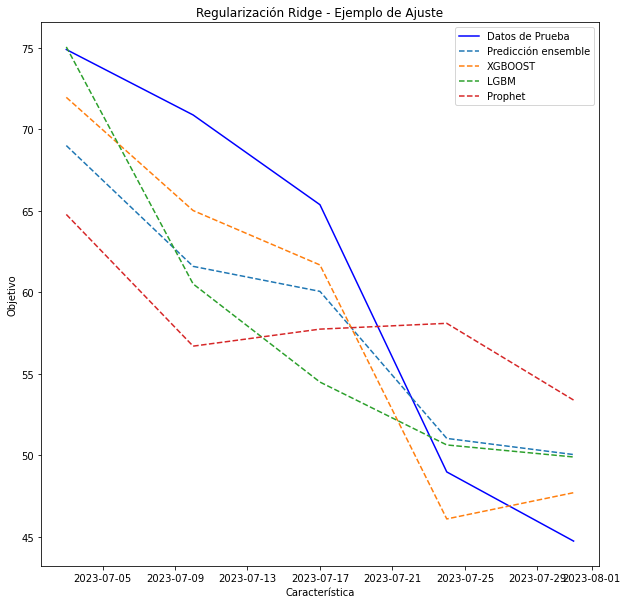

------------


In [52]:
# Realizar predicciones en el conjunto de prueba
y_pred_ridge = ((ridge_adapt.coef_ /sum(ridge_adapt.coef_))*ensemb_test).sum(axis=1, numeric_only=True)

# Calcular el error en el conjunto de prueba

print_fit_metrics(y_test, y_pred_ridge.values)



# Visualizar el ajuste del modelo
plt.plot(ts_data_xg_test.index, y_test, color='blue', label='Datos de Prueba')
plt.plot(ts_data_xg_test.index, y_pred_ridge, label='Predicción ensemble', linestyle='dashed')
#plt.plot(ts_data_xg_test.index, forecast_arima, label='ARIMA', linestyle='dashed')
#plt.plot(ts_data_xg_test.index, forecast_sarima.predicted_mean, label='SARIMA', linestyle='dashed')
plt.plot(ts_data_xg_test.index, y_pred_xg_t_test, label='XGBOOST', linestyle='dashed')
plt.plot(ts_data_xg_test.index, y_pred_lgb_t_test, label='LGBM', linestyle='dashed')
plt.plot(ts_data_xg_test.index, prophet_pred2.values, label='Prophet', linestyle='dashed')




plt.title('Regularización Ridge - Ejemplo de Ajuste')
plt.xlabel('Característica')
plt.ylabel('Objetivo')
plt.legend()
plt.show()
print('------------')

In [53]:
ridge_adapt.coef_


array([1.0059531, 0.       , 0.7038569])

In [54]:
ridge_adapt

Ridge(alpha=0.001, fit_intercept=False, positive=True, solver='lbfgs')

In [55]:
m = Prophet()
prophet_input = pd.DataFrame()


prophet_input['ds'] = ts_data[:'2023-06-26'].index
prophet_input['y'] = ts_data[:'2023-06-26'].values

#ts_data['2023-07-03':'2023-07-31']

m.fit(prophet_input)

future = m.make_future_dataframe(periods=5, freq='W')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

prophet_pred = forecast['yhat'].iloc[forecast.shape[0]-5:,]
prophet_pred

20:09:54 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing


181    64.772458
182    56.701066
183    57.743990
184    58.099793
185    53.395360
Name: yhat, dtype: float64